<a href="https://colab.research.google.com/github/FarnazG/dsc-capstone-project-v2-online-ds-ft-120919/blob/master/final_capstone_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook, we are going to explore the **one_vs_all+ Transfer learning:**

outlines:
1. we have images as our input or X, and brand names as labels or Y.

2. we will create a model for each brand with binary classifier, to classifies if an image belonges to that brand or not.

3. after we are done modeling all our 5 brands, we will combine all results through the maximum score to get the final brand recognition.

4. the more important note here is to check the balance of data in this case, each time we are running the model for each individual brand, the distribution of the brand would be imbalanced compare to the rest of brands, most of them are 0, so we have to generate images and positive data to make a balance dataset for each iteration over brand and its model.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
import seaborn as sns
import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset
from sklearn.multiclass import OneVsRestClassifier

#All tensorflow utilities for creating, training and working with a CNN
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
# from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
# from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.models import load_model

#All tensorflow utilities for creating, training and working with a CNN
from keras import losses
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input #, merge
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
#from tensorflow.keras.models import load_model, Model
from keras.models import load_model, Model
from keras.regularizers import l2
#from tensorflow.keras.utils import np_utils

from scipy import ndimage, misc

# **After 'X' is downloaded:**


In [0]:
# some URL images that were not readable were deleted:
X3 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df2598.npy') 
X2 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df2000.npy') 
X1 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df1000.npy') 
X = np.concatenate((X1, X2, X3))
print(X.shape)


(2598, 120000)


To see how well the image processing works , we will fetch 5 samples from 'X' at random and plot them:

**Splitting the data:**

We need to split the data into training, validation, and test sets.

**Creating the Target Array:**

We already have our 'X'. Now, we need our 'Y'.

We will ceate it from the 'brand.name' column of our dataframe.

this column consists of the categorical labels. then We will map each label with a number using the LabelEncoder.

In [0]:
df= pd.read_csv('/content/drive/My Drive/Capstone Project/df.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
0,0,41,3440,Dolce & Gabbana,women,True,13951532,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,1124,"$1,124","$1,124",1124,False,Geranium print mini dress,38
1,1,57,25354,Gucci,women,True,13579955,https://cdn-images.farfetch-contents.com/13/57...,https://cdn-images.farfetch-contents.com/13/57...,False,NoTag,9359,SGD,2200,"$2,200","$2,200",2200,False,Stirrups print blouse,13
2,2,122,547344,Saint Laurent,women,True,14031265,https://cdn-images.farfetch-contents.com/14/03...,https://cdn-images.farfetch-contents.com/14/03...,False,NewSeason,9359,SGD,2620,"$2,620","$2,620",2620,False,Zebra print peplum skirt,4
3,3,128,3440,Dolce & Gabbana,women,True,13951202,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,3200,"$3,200","$3,200",3200,False,Lily print flounce dress,18
4,4,96,3440,Dolce & Gabbana,women,True,13922305,https://cdn-images.farfetch-contents.com/13/92...,https://cdn-images.farfetch-contents.com/13/92...,False,NoTag,9541,SGD,4273,"$4,273","$4,273",4273,False,graffiti art print jacket,1


In [0]:
#create dummy variables for 'brand.name' feature:
Y= pd.get_dummies(df['brand.name'])
type(Y.to_numpy())
# print(type(Y))
# Z = Y.iloc[:,0]
# print(type(Z))
#Y.to_numpy()[:,0]


numpy.ndarray

In [0]:
# from sklearn.preprocessing import LabelEncoder
# lbEnc=LabelEncoder()
# Y=lbEnc.fit_transform(df["brand.name"])
# Y

Chanel Pre-Owned    730
Dolce & Gabbana     597
Prada               496
Saint Laurent       410
Gucci               365
Name: brand.name, dtype: int64


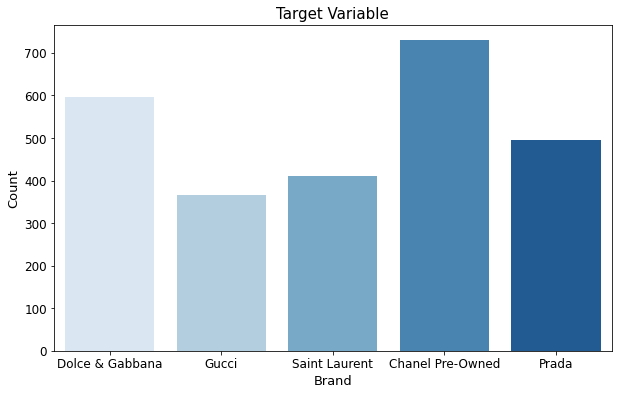

In [0]:
# Check on the data balance
print(df['brand.name'].value_counts())

plt.figure(figsize=(10,6))
sns.countplot(df['brand.name'], palette='Blues')
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Target Variable', size = 15)
plt.xlabel('Brand', size = 13)
plt.ylabel('Count', size = 13);

In [0]:
#Define a Convolutional Neural Network Model for the original model
def loadOriginalModel(input_tensor=None, n_classes=1000):

  img_input = input_tensor

  #model = Sequential()
  x=Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', name="Conv2d_1")(img_input)
  x=BatchNormalization(name="BN_1")(x)
  x=Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', name="Conv2d_2")(x)
  x=BatchNormalization(name="BN_2")(x)
  x=MaxPool2D(strides=(2,2))(x)
  x=Dropout(0.25, name="Drp_1")(x)
  
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_3")(x)
  x=BatchNormalization(name="BN_3")(x)
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_4")(x)
  x=BatchNormalization(name="BN_4")(x)
  x=MaxPool2D(strides=(2,2))(x)
  x=Dropout(0.25, name="Drp_2")(x)
  
  x=Flatten()(x)
  x=Dense(512, activation='relu', name="Dense_1")(x)
  x=Dropout(0.25)(x)
  
  x=Dense(1024, activation='relu', name="Dense_2")(x)
  x=Dropout(0.4)(x)

  x=Dense(n_classes, activation='softmax')(x)

  model = Model(img_input, x)
  return model

In [0]:
original_input = Input(shape=(100, 100, 1), name='original_input')
original_model = loadOriginalModel(input_tensor=original_input, n_classes=17)
original_model.load_weights('/content/drive/My Drive/Capstone Project/model_org.hdf5')
original_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  (None, 100, 100, 1)       0         
_________________________________________________________________
Conv2d_1 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 98, 98, 16)        64        
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
Drp_1 (Dropout)              (None, 48, 48, 16)        0   

In [0]:
#Define a Convolutional Neural Network Model for custom input
def loadCustomModel(input_tensor=None, n_classes=1000):

  img_input = input_tensor

  #model = Sequential()
  x=Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', name="Conv2d_1")(img_input)
  x=BatchNormalization(name="BN_1")(x)
  x=Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', name="Conv2d_2")(x)
  x=BatchNormalization(name="BN_2")(x)
  x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_1")(x)
  
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_3")(x)
  x=BatchNormalization(name="BN_3")(x)
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_4")(x)
  x=BatchNormalization(name="BN_4")(x)
  x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_2")(x)
  
  # We add two conv layers to the custom model which helps reduce the number of parameters in the custom mode,
  # since the custom model's input shape is different than the original model's input shape
  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_5")(x)
  x=BatchNormalization(name="BN_5")(x)
  x=MaxPool2D(strides=(4,4))(x)
  #x=Dropout(0.5, name="Drp_3")(x)

  x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_6")(x)
  x=BatchNormalization(name="BN_6")(x)
  x=MaxPool2D(strides=(4,4))(x)
  #x=Dropout(0.5, name="Drp_4")(x)

  # x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_7")(x)
  # x=BatchNormalization(name="BN_7")(x)
  # x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_5")(x)

  # x=Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', name="Conv2d_8")(x)
  # x=BatchNormalization(name="BN_8")(x)
  # x=MaxPool2D(strides=(2,2))(x)
  #x=Dropout(0.5, name="Drp_6")(x)

  x=Flatten()(x)
  x=Dense(512, activation='relu', name="Dense_1", kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(x)
  x=Dropout(0.25)(x)
  
  x=Dense(1024, activation='relu', name="Dense_2", kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(x)
  x=Dropout(0.25)(x)

  x=Dense(n_classes, activation='sigmoid')(x)

  model = Model(img_input, x)
  
  return model

In [0]:
custom_input = Input(shape=(400, 300, 1), name='new_input')
custom_model = loadCustomModel(input_tensor=custom_input, n_classes=1)

layer_name_list = ['Conv2d_1', 'Conv2d_2', 'Conv2d_3', 'Conv2d_4', 'BN_1', 'BN_2', 'BN_3', 'BN_4']

for layer_name in layer_name_list:
  custom_model.get_layer(name=layer_name).set_weights(original_model.get_layer(name=layer_name).get_weights())
  custom_model.get_layer(name=layer_name).trainable = False

#layer_name_list = ['Conv2d_5', 'Conv2d_6', 'Conv2d_7', 'Conv2d_8']
layer_name_list = ['Conv2d_5', 'Conv2d_6']

for layer_name in layer_name_list:
  custom_model.get_layer(name=layer_name).set_weights(original_model.get_layer(name='Conv2d_4').get_weights())
  custom_model.get_layer(name=layer_name).trainable = False

#layer_name_list = ['BN_5', 'BN_6', 'BN_7', 'BN_8']
layer_name_list = ['BN_5', 'BN_6']

for layer_name in layer_name_list:
  custom_model.get_layer(name=layer_name).set_weights(original_model.get_layer(name='BN_4').get_weights())
  custom_model.get_layer(name=layer_name).trainable = False

learning_rate = 0.01

custom_model.compile(loss = binary_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

custom_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
new_input (InputLayer)       (None, 400, 300, 1)       0         
_________________________________________________________________
Conv2d_1 (Conv2D)            (None, 398, 298, 16)      160       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 398, 298, 16)      64        
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 396, 296, 16)      2320      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 396, 296, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 198, 148, 16)      0         
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 196, 146, 32)      4640

augmentationRatio: 2
730


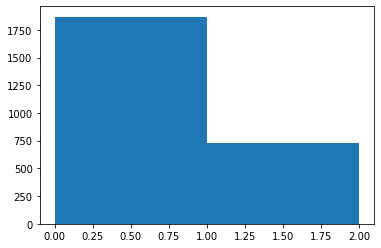

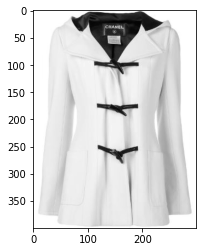

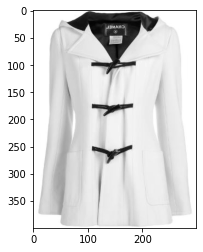

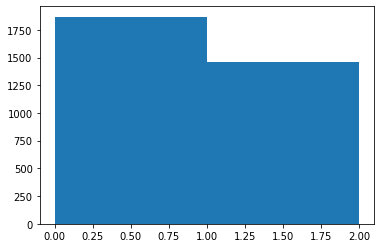

Train on 2496 samples, validate on 665 samples
Epoch 1/20
2496/2496 [==============================] - 133s 53ms/step - loss: 13.7096 - accuracy: 0.5649 - val_loss: 1.1450 - val_accuracy: 0.6150
Epoch 2/20
2496/2496 [==============================] - 131s 53ms/step - loss: 0.9068 - accuracy: 0.5849 - val_loss: 0.9042 - val_accuracy: 0.5895
Epoch 3/20
2496/2496 [==============================] - 132s 53ms/step - loss: 0.8747 - accuracy: 0.5669 - val_loss: 0.8822 - val_accuracy: 0.5534
Epoch 4/20
2496/2496 [==============================] - 131s 53ms/step - loss: 0.8387 - accuracy: 0.5701 - val_loss: 0.7934 - val_accuracy: 0.5519
Epoch 5/20
2496/2496 [==============================] - 132s 53ms/step - loss: 0.7954 - accuracy: 0.5585 - val_loss: 0.7640 - val_accuracy: 0.5519
Epoch 6/20
2496/2496 [==============================] - 131s 52ms/step - loss: 0.8549 - accuracy: 0.5769 - val_loss: 0.9157 - val_accuracy: 0.5519
Epoch 7/20
2496/2496 [==============================] - 130s 52ms/step

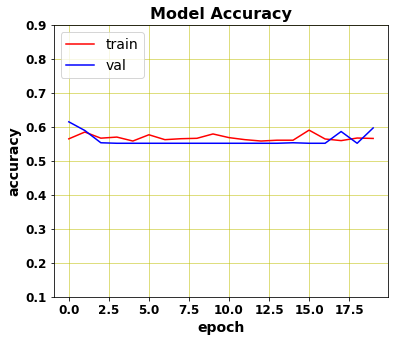

augmentationRatio: 3
597


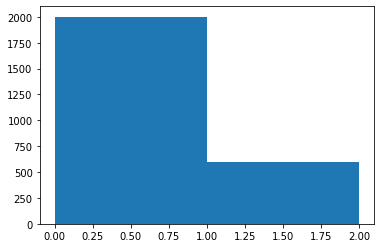

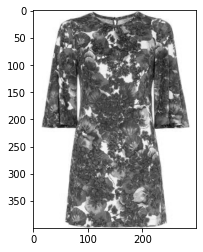

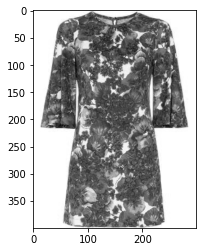

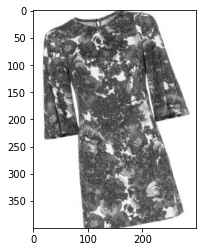

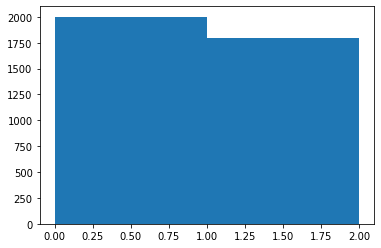

Train on 2844 samples, validate on 758 samples
Epoch 1/20
2844/2844 [==============================] - 141s 50ms/step - loss: 1.9334 - accuracy: 0.5577 - val_loss: 4.3698 - val_accuracy: 0.4855
Epoch 2/20
2844/2844 [==============================] - 141s 49ms/step - loss: 20.3223 - accuracy: 0.4951 - val_loss: 15.7034 - val_accuracy: 0.5422
Epoch 3/20
2844/2844 [==============================] - 140s 49ms/step - loss: 20.2738 - accuracy: 0.5348 - val_loss: 14.7555 - val_accuracy: 0.5092
Epoch 4/20
2844/2844 [==============================] - 141s 49ms/step - loss: 8.0919 - accuracy: 0.5475 - val_loss: 10.5538 - val_accuracy: 0.5831
Epoch 5/20
2844/2844 [==============================] - 144s 51ms/step - loss: 6.5238 - accuracy: 0.5584 - val_loss: 3.3368 - val_accuracy: 0.4855
Epoch 6/20
2844/2844 [==============================] - 142s 50ms/step - loss: 2.2598 - accuracy: 0.6030 - val_loss: 1.3704 - val_accuracy: 0.6069
Epoch 7/20
2844/2844 [==============================] - 142s 50ms/

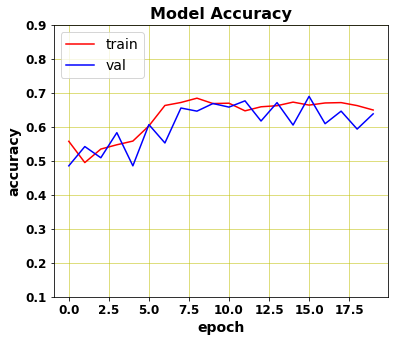

augmentationRatio: 6
365


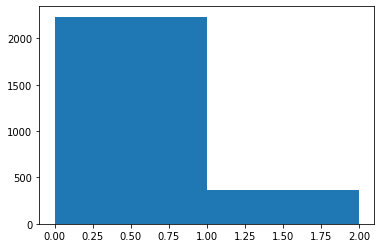

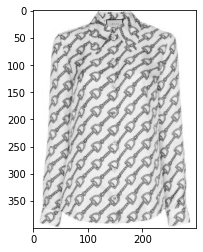

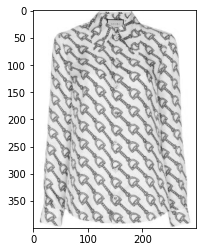

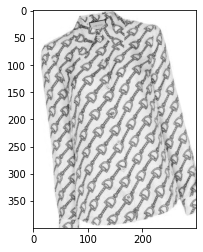

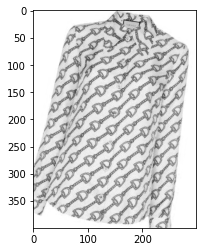

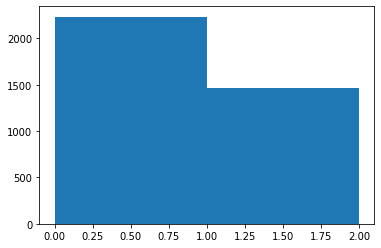

Train on 2769 samples, validate on 739 samples
Epoch 1/20
2769/2769 [==============================] - 140s 51ms/step - loss: 0.8784 - accuracy: 0.6056 - val_loss: 0.7981 - val_accuracy: 0.5995
Epoch 2/20
2769/2769 [==============================] - 142s 51ms/step - loss: 0.7939 - accuracy: 0.6053 - val_loss: 0.8483 - val_accuracy: 0.5995
Epoch 3/20
2769/2769 [==============================] - 140s 50ms/step - loss: 0.8039 - accuracy: 0.6085 - val_loss: 0.7783 - val_accuracy: 0.5995
Epoch 4/20
2769/2769 [==============================] - 140s 51ms/step - loss: 0.8242 - accuracy: 0.6129 - val_loss: 0.8600 - val_accuracy: 0.5995
Epoch 5/20
2769/2769 [==============================] - 140s 51ms/step - loss: 0.8212 - accuracy: 0.6046 - val_loss: 0.8583 - val_accuracy: 0.5968
Epoch 6/20
2769/2769 [==============================] - 142s 51ms/step - loss: 0.8010 - accuracy: 0.6092 - val_loss: 0.7739 - val_accuracy: 0.5995
Epoch 7/20
2769/2769 [==============================] - 140s 50ms/step 

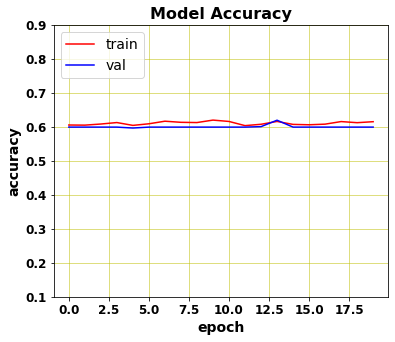

augmentationRatio: 4
496


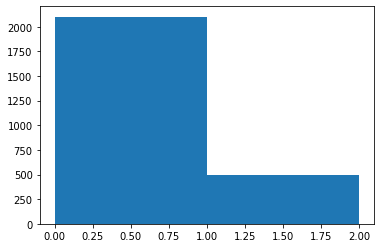

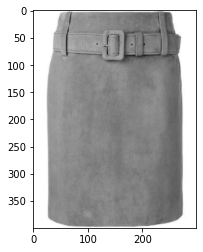

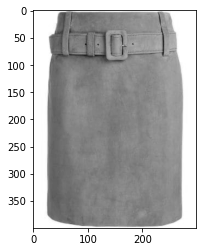

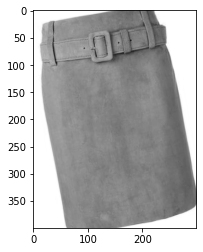

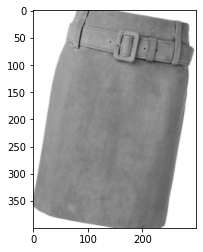

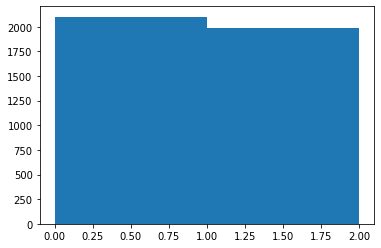

Train on 3064 samples, validate on 817 samples
Epoch 1/20
3064/3064 [==============================] - 151s 49ms/step - loss: 0.8394 - accuracy: 0.5366 - val_loss: 0.9128 - val_accuracy: 0.5190
Epoch 2/20
3064/3064 [==============================] - 151s 49ms/step - loss: 0.8427 - accuracy: 0.5441 - val_loss: 0.7889 - val_accuracy: 0.5190
Epoch 3/20
3064/3064 [==============================] - 153s 50ms/step - loss: 0.8021 - accuracy: 0.5496 - val_loss: 0.8649 - val_accuracy: 0.5655
Epoch 4/20
3064/3064 [==============================] - 157s 51ms/step - loss: 0.8452 - accuracy: 0.5392 - val_loss: 0.7688 - val_accuracy: 0.5569
Epoch 5/20
3064/3064 [==============================] - 152s 50ms/step - loss: 0.7750 - accuracy: 0.5457 - val_loss: 0.7668 - val_accuracy: 0.5141
Epoch 6/20
3064/3064 [==============================] - 150s 49ms/step - loss: 0.7806 - accuracy: 0.5480 - val_loss: 0.9280 - val_accuracy: 0.5275
Epoch 7/20
3064/3064 [==============================] - 153s 50ms/step 

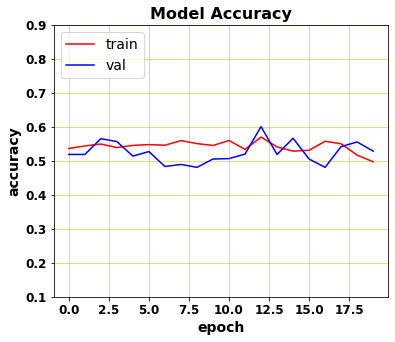

augmentationRatio: 5
410


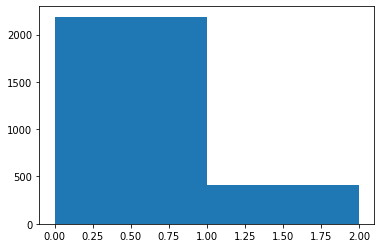

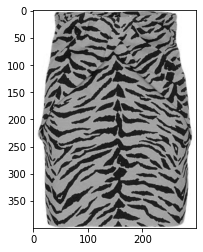

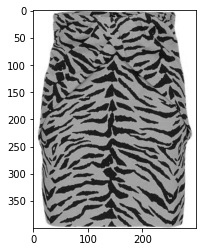

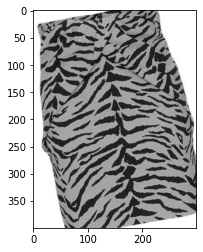

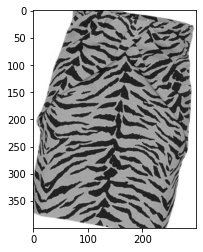

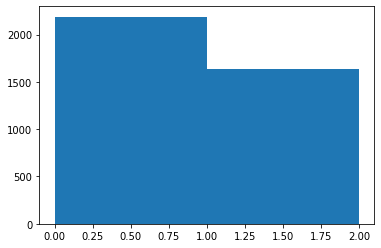

Train on 2871 samples, validate on 765 samples
Epoch 1/20
2871/2871 [==============================] - 142s 49ms/step - loss: 41.3379 - accuracy: 0.5277 - val_loss: 14.4451 - val_accuracy: 0.5725
Epoch 2/20
2871/2871 [==============================] - 144s 50ms/step - loss: 8.5593 - accuracy: 0.5740 - val_loss: 4.9078 - val_accuracy: 0.5817
Epoch 3/20
2871/2871 [==============================] - 145s 50ms/step - loss: 6.4246 - accuracy: 0.5611 - val_loss: 2.6124 - val_accuracy: 0.5660
Epoch 4/20
2871/2871 [==============================] - 142s 49ms/step - loss: 2.2096 - accuracy: 0.5817 - val_loss: 1.5613 - val_accuracy: 0.6484
Epoch 5/20
2871/2871 [==============================] - 141s 49ms/step - loss: 1.4269 - accuracy: 0.6238 - val_loss: 1.1174 - val_accuracy: 0.5948
Epoch 6/20
2871/2871 [==============================] - 142s 49ms/step - loss: 1.0565 - accuracy: 0.6228 - val_loss: 0.9812 - val_accuracy: 0.5830
Epoch 7/20
2871/2871 [==============================] - 143s 50ms/ste

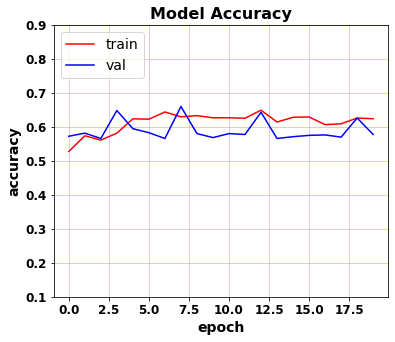

In [0]:
for i in range(0, 5):

  # we Separate 75% of our data as training, 20% as validation, and 5% as test dataset. We also shuffle the 
  # data set before spliting into training, validation and test data sets.

  # Generating more data through image augmentation:
  otherBrandsNum = Y.iloc[:,i].value_counts()[0]
  brandNum = Y.iloc[:,i].value_counts()[1]
  augmentationRatio = int(otherBrandsNum/brandNum)

  print("augmentationRatio:", augmentationRatio)

  idxList = Y[Y.iloc[:,i]==1].index.tolist()
  print(len(idxList))

  XS = X[idxList]  
  X1 = XS.reshape(XS.shape[0], 400, 300)
  
  plt.figure()
  plt.hist(Y.to_numpy()[:,i], bins=[0,1,2])

  plt.figure()
  plt.imshow(X1[0], cmap='gray')

  #Xout=np.empty()
  
  # Flip image horizontally
  if 1<augmentationRatio:
    flippedX = np.flip(X1,axis=2)
    Xout = flippedX
    plt.figure()
    plt.imshow(flippedX[0], cmap='gray')
  
  # Roate image 10deg clockwise
  if 2<augmentationRatio:
    rotated10pX = np.zeros(X1.shape)
    for j in range(0, X1.shape[0]):
      rotated10pX[j] = ndimage.rotate(X1[j], 10, reshape=False, cval=255.0)
    Xout=np.concatenate((Xout,rotated10pX))
    plt.figure()
    plt.imshow(rotated10pX[0], cmap='gray')
  
  # Rotate image 10deg counter clockwise
  if 3<augmentationRatio:
    rotated10mX = np.zeros(X1.shape)
    for j in range(0, X1.shape[0]):
      rotated10mX[j] = ndimage.rotate(X1[j], -10, reshape=False, cval=255.0)
    Xout=np.concatenate((Xout,rotated10mX))
    plt.figure()
    plt.imshow(rotated10mX[0], cmap='gray')
  
  plt.show()
  
  Yout=np.ones(Xout.shape[0])
  Yout=np.concatenate((Y.to_numpy()[:,i],Yout))
  
  Xout=np.reshape(Xout, (Xout.shape[0], 300*400))
  Xout=np.concatenate((X,Xout))

  # Xl=Xout[3002,:]
  # Xl=np.reshape(Xl, (400, 300))
  # plt.figure()
  # plt.imshow(Xl, cmap='gray')

  #Split and shuffle the data:
  
  X_train, X_val, Y_train, Y_val = train_test_split(Xout, Yout, test_size=0.25, shuffle=True)

  X_test = X_val[int(0.8*X_val.shape[0]):,]
  Y_test = Y_val[int(0.8*Y_val.shape[0]):,]

  X_val = X_val[0:int(0.8*X_val.shape[0]),]
  Y_val = Y_val[0:int(0.8*Y_val.shape[0]),]


  #Reshape the input matrices such that each sample is three-dimensional
  img_rows, img_cols = 400, 300
  input_shape = (400, 300, 1)
  
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
  X_train = X_train/255
  X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
  X_test = X_test/255
  X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
  X_val = X_val/255

  plt.figure()
  plt.hist(Yout, bins=[0,1,2])
  plt.show()

  Xout=[]
  Yout=[]

  #Save the model during training 
  save_at = "/content/drive/My Drive/Capstone Project/stacking_model_" + str(i)+ "_10.hdf5"
  save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

  #Train the CNN
  history = custom_model.fit(X_train, Y_train,
                             epochs = 20, batch_size = 50,
                             callbacks=[save_best], verbose=1,
                             validation_data = (X_val, Y_val))
  
  # Plot the training history (Training accuracy & Validation accuracy)
  plt.figure(figsize=(6, 5))
  plt.plot(history.history['accuracy'], color='r')
  plt.plot(history.history['val_accuracy'], color='b')
  plt.title('Model Accuracy', weight='bold', fontsize=16)
  plt.ylabel('accuracy', weight='bold', fontsize=14)
  plt.xlabel('epoch', weight='bold', fontsize=14)
  plt.ylim(0.1, 0.9)
  plt.xticks(weight='bold', fontsize=12)
  plt.yticks(weight='bold', fontsize=12)
  plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
  plt.grid(color = 'y', linewidth='0.5')
  plt.show()
  


**Combining the results:**

In [0]:
model_list=[]
for i in range(0,5):
  model = load_model("/content/drive/My Drive/Capstone Project/stacking_model_" + str(i)+ "_10.hdf5")
  model_list.append(model)

In [0]:
X_train = np.copy(X)

X_train = X_train.reshape(X_train.shape[0], 400, 300, 1)
X_train = X_train/255

predictions=np.zeros(shape=(X_train.shape[0],5))
for i in range(0,5):
  predictions[:,i] = np.squeeze(model_list[i].predict(X_train))
  
predictions
  
  #score = model.evaluate(X_test, Y_test, verbose=0)

array([[0.44077778, 0.49682704, 0.42341825, 0.46039578, 0.49480164],
       [0.43407124, 0.49382615, 0.4359127 , 0.49962133, 0.36560097],
       [0.4673779 , 0.48516312, 0.41202521, 0.44031012, 0.45848513],
       ...,
       [0.46219459, 0.47392008, 0.45381883, 0.51232743, 0.27040711],
       [0.51555461, 0.38154823, 0.31024021, 0.4951041 , 0.52059889],
       [0.46068096, 0.43752366, 0.40558076, 0.50673121, 0.33799344]])

**Success rate:**

In [0]:
final_prediction=np.argmax(predictions, axis=1)

from sklearn.preprocessing import LabelEncoder
lbEnc=LabelEncoder()
groundTruth=lbEnc.fit_transform(df["brand.name"])

successRate = np.count_nonzero((final_prediction - groundTruth))/groundTruth.shape[0]
print(successRate)

0.6335642802155504


So, our final model combination of one-vs-all strategy and transfer learning reached %66 success rate which is acceptable, we finish our project here.